### LangGraph : Highly customizable and flexible Agents

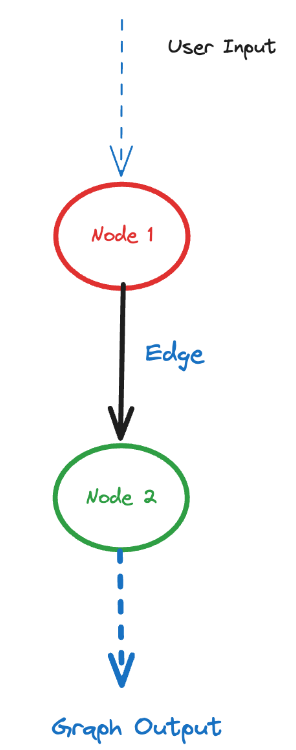

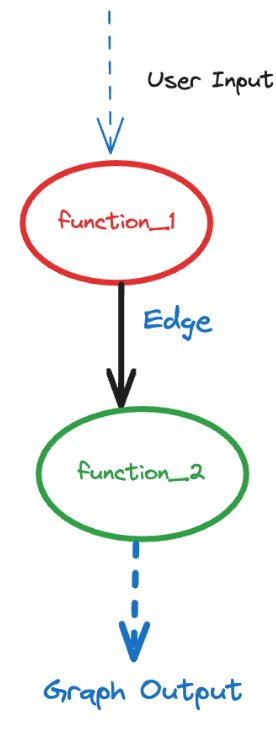

In [3]:
def function_1(input_1):
    return input_1 + " First Function "

def function_2(input_2):
    return input_2 + " to Second Function"

In [4]:
from langgraph.graph import Graph

In [5]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('node_1', 'node_2')

workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [6]:
app.invoke('I am moving from')

'I am moving from First Function  to Second Function'

In [7]:
input = 'I am moving from'
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
I am moving from First Function 

---

Output from node 'node_2':
---
I am moving from First Function  to Second Function

---



### Integrating LLM call in the LangGraph

In [8]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [9]:
from utils.llm import LLM
llms = LLM()
embedding_model = llms.get_azure_embedding
llm = llms.get_azure_openai()

In [10]:
llm.invoke('Hi').content

'Hello! How can I assist you today?'

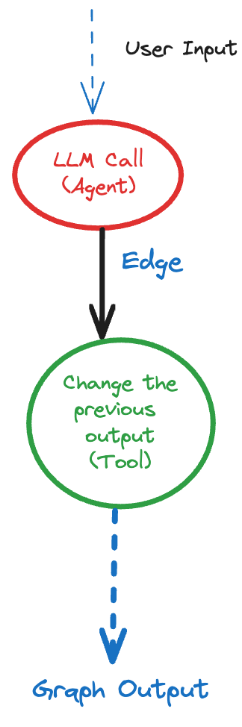

In [13]:
def function_1(input_1):
    complete_query = "Your task is to provide only the topic based on the user query. \
        Only output the topic among: [Japan , Sports]. Don't include reasoning. Following is the user query: " + input_1
    response = llm.invoke(complete_query)
    return response.content

def function_2(input_2):
    TOPIC_UPPER = input_2.upper()
    response = f"Here is the topic in UPPER case: {TOPIC_UPPER}"
    return response

In [14]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("Agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge('Agent', 'tool')

workflow.set_entry_point("Agent")
workflow.set_finish_point("tool")

app = workflow.compile()

In [15]:
query = "Tell me about Japan's Industrial Growth"
app.invoke(query)

'Here is the topic in UPPER case: JAPAN'

In [16]:
for output in app.stream(query):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Agent':
---
Japan

---

Output from node 'tool':
---
Here is the topic in UPPER case: JAPAN

---



### RAG Pipeline integration

In [17]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

### Reading the txt files from source directory

loader = DirectoryLoader('./source', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]


### Creating Retriever using Vector DB

db = Chroma.from_documents(new_docs, embedding_model())
retriever = db.as_retriever(search_kwargs={"k": 4})

### Testing the retriever

In [18]:
query = "Tell me about Japan's Industrial Growth"
docs = retriever.get_relevant_documents(query)
print(docs)

C:\Users\10742902\AppData\Local\Temp\ipykernel_20612\4118393923.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


[Document(metadata={'source': 'source\\japan.txt'}, page_content='Industrial revival hope for Japan'), Document(metadata={'source': 'source\\japan.txt'}, page_content="Japan's last four year GDP:"), Document(metadata={'source': 'source\\japan.txt'}, page_content="exports, normally the engine for Japan's economy in the face of weak domestic demand, had helped"), Document(metadata={'source': 'source\\japan.txt'}, page_content="Japanese industry is growing faster than expected, boosting hopes that the country's retreat back")]


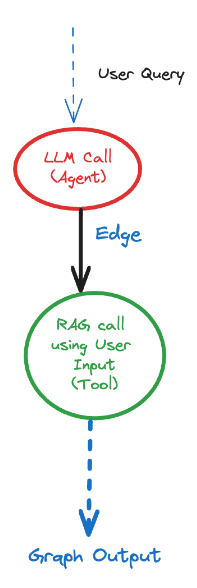

### Integrating RAG pipeline with LangGraph and AgentState

In [19]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

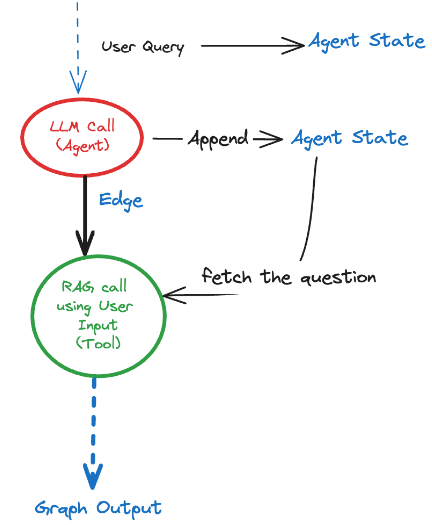

In [20]:
# assign AgentState as an empty dict
AgentState = {}

# messages key will be assigned as an empty array. We will append new messages as we pass along nodes. 
AgentState["messages"] = []

In [21]:
AgentState

{'messages': []}

In [22]:
def function_1(state):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    
    complete_query = "Your task is to provide only the topic based on the user query. \
        Only output the topic among: [Japan , Sports]. Don't include reasoning. Following is the user query: " + question
    response = llm.invoke(complete_query)
    state['messages'].append(response.content) # appending LLM call response to the AgentState
    return state

def function_2(state):
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [23]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("Agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge('Agent', 'tool')

workflow.set_entry_point("Agent")
workflow.set_finish_point("tool")

app = workflow.compile()

In [24]:
inputs = {"messages": ["Tell me about Japan's Industrial Growth"]}
app.invoke(inputs)

"Japanese industry is growing faster than expected, boosting hopes for an industrial revival in the country. This growth is particularly significant as exports, which are typically the main driver of Japan's economy in the face of weak domestic demand, have played a crucial role in this resurgence."

In [ ]:
inputs = {"messages": ["Who came fourth for Ireland at the outdoor European Running Championships in 1998?"]}
app.invoke(inputs)

In [25]:
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Agent':
---
{'messages': ["Tell me about Japan's Industrial Growth", 'Japan', 'Japan']}

---

Output from node 'tool':
---
Japanese industry is growing faster than expected, boosting hopes for the country's industrial revival.

---



### Simplyfying the State addition and maintainence

In [26]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### Making Complex Graphs with Conditional Edges

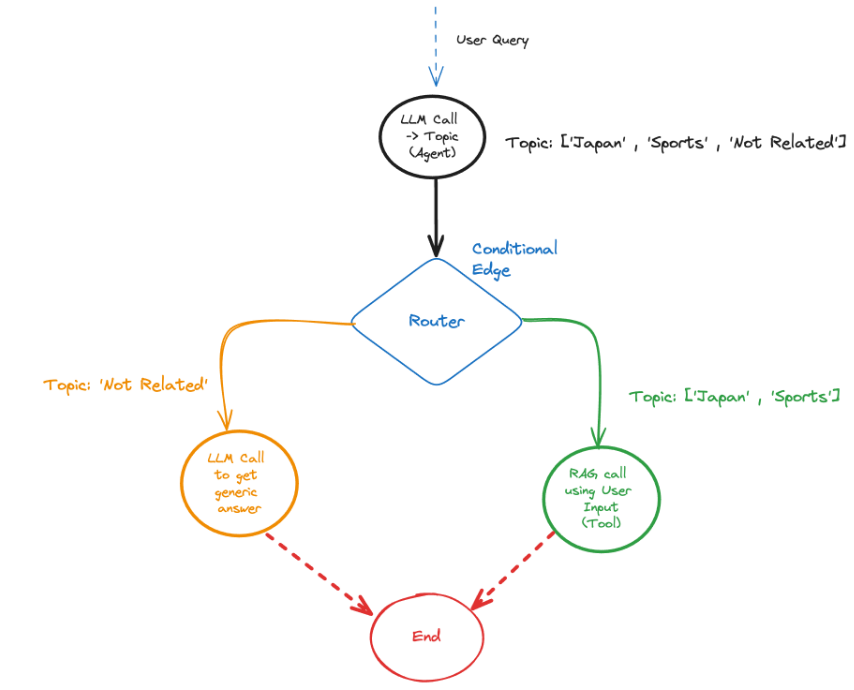

In [31]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate


class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    #Reasoning: str = Field(description='Reasoning behind topic selection')

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [32]:
def function_1(state):
    print('-> Calling Agent ->')
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    
    templete = """ Your task is to provide only the topic based on the user query. 
        Only output the topic among: [Japan , Sports , Not Related]. Don't include reasoning. Following is the user query:  {question}
        {format_instructions} """
    prompt = PromptTemplate(template=templete,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain = prompt | llm | parser

    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}


def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'Japan' in last_message or 'Sports' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [33]:
from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("agent", function_1)
graph.add_node("RAG", function_2)
graph.add_node("LLM", function_3)

graph.set_entry_point("agent")


# conditional edges are controlled by our router
graph.add_conditional_edges(
    "agent",  # where in graph to start
    router,  # function to determine which node is called
    {                               # Conditional routing
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

graph.add_edge("RAG", END)
graph.add_edge("LLM", END)

app = graph.compile()

In [34]:
inputs = {"messages": ["Tell me about Japan's Industrial Growth"]}
out = app.invoke(inputs)

-> Calling Agent ->
Topic='Japan'
-> Router ->
Japan
-> Calling RAG ->


In [35]:
out['messages']

["Tell me about Japan's Industrial Growth",
 'Japan',
 'Japanese industry is growing faster than expected, boosting hopes for an industrial revival and economic improvement for the country.']

In [36]:
out['messages'][-1]

'Japanese industry is growing faster than expected, boosting hopes for an industrial revival and economic improvement for the country.'

In [37]:
inputs = {"messages": ["Who came fourth for Ireland at the outdoor European Running Championships in 1998?"]}
out = app.invoke(inputs)
print(out)

-> Calling Agent ->
Topic='Sports'
-> Router ->
Sports
-> Calling RAG ->
{'messages': ['Who came fourth for Ireland at the outdoor European Running Championships in 1998?', 'Sports', 'The context provided does not explicitly mention who came fourth for Ireland at the outdoor European Running Championships in 1998. However, it does mention that McIlroy claims to be in his best shape since finishing fourth for Ireland at an outdoor event, which could imply that McIlroy is the person who came fourth for Ireland at the outdoor European Running Championships in 1998.']}


In [38]:
inputs = {"messages": ["Tell me about Bert Model"]}
out = app.invoke(inputs)

-> Calling Agent ->
Topic='Not Related'
-> Router ->
Not Related
-> Calling LLM ->


In [39]:
print(out['messages'])

['Tell me about Bert Model', 'Not Related', 'The BERT model, which stands for Bidirectional Encoder Representations from Transformers, is a state-of-the-art natural language processing (NLP) model developed by Google and introduced in a 2018 paper by Jacob Devlin and his colleagues. BERT is designed to understand the context of words in a sentence by looking at the words that come before and after them, making it bidirectional.\n\nKey features of BERT include:\n\n1. **Bidirectionality**: Unlike traditional NLP models that process text in a unidirectional manner (left-to-right or right-to-left), BERT processes text in both directions simultaneously. This allows the model to capture more context and nuances of the language.\n\n2. **Transformer Architecture**: BERT is based on the Transformer architecture, which relies on self-attention mechanisms to weigh the importance of different words in a sentence. This architecture enables BERT to handle long-range dependencies and relationships be

In [40]:
print(out['messages'][-1])

The BERT model, which stands for Bidirectional Encoder Representations from Transformers, is a state-of-the-art natural language processing (NLP) model developed by Google and introduced in a 2018 paper by Jacob Devlin and his colleagues. BERT is designed to understand the context of words in a sentence by looking at the words that come before and after them, making it bidirectional.

Key features of BERT include:

1. **Bidirectionality**: Unlike traditional NLP models that process text in a unidirectional manner (left-to-right or right-to-left), BERT processes text in both directions simultaneously. This allows the model to capture more context and nuances of the language.

2. **Transformer Architecture**: BERT is based on the Transformer architecture, which relies on self-attention mechanisms to weigh the importance of different words in a sentence. This architecture enables BERT to handle long-range dependencies and relationships between words effectively.

3. **Pre-training and Fin